## Practica 2 - Parte 1
### Perceptron

#### Importar librerías:

In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import tabulate

#### Dataset:
Cargamos el dataset de iris de la libreria sklearn, al cargar load_iris en iris obtenemos diferentes sets de informacion, guardamos la informacion que nos interesa en un daframe de pandas.

Elimino del dataset los de target = 2 por que solo tenemos que diferenciar entre 2 tipos de iris

In [2]:
np.random.seed(1234)
tf.random.set_seed(1234)
iris = datasets.load_iris()
print(iris.DESCR)


.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

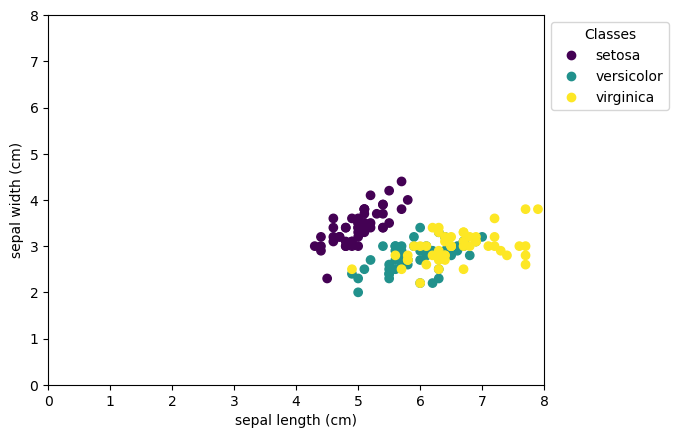

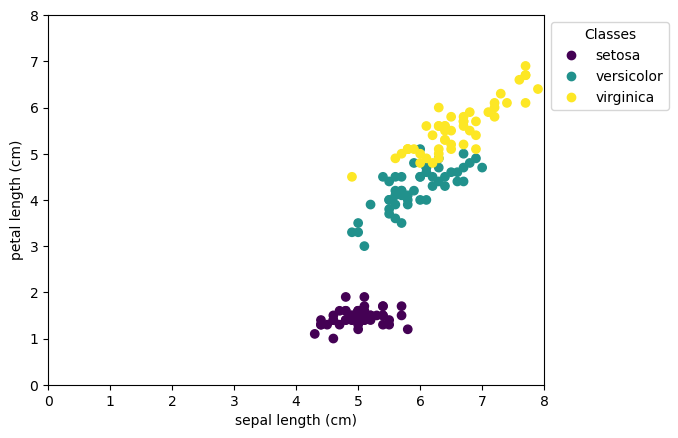

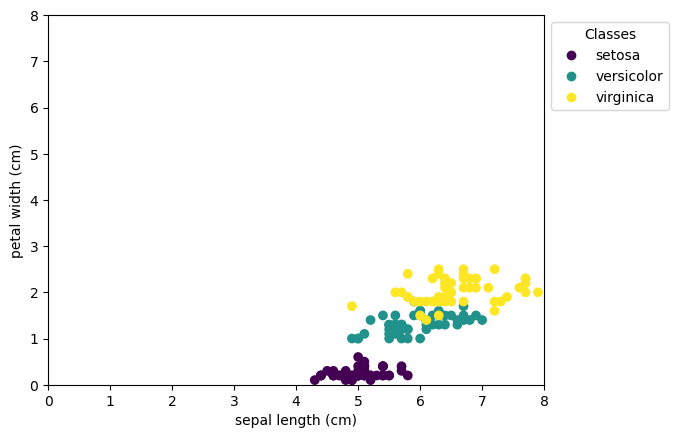

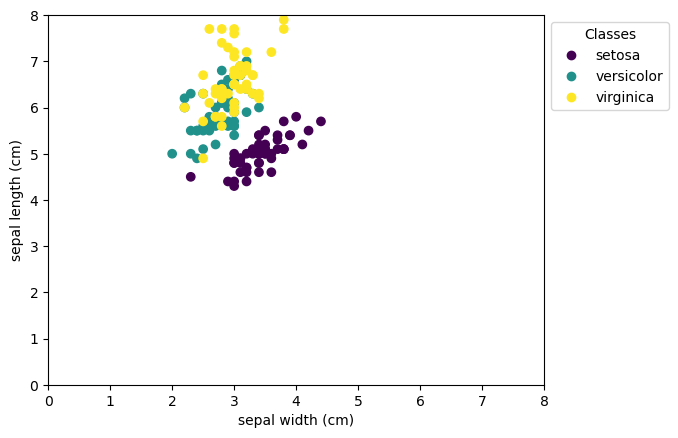

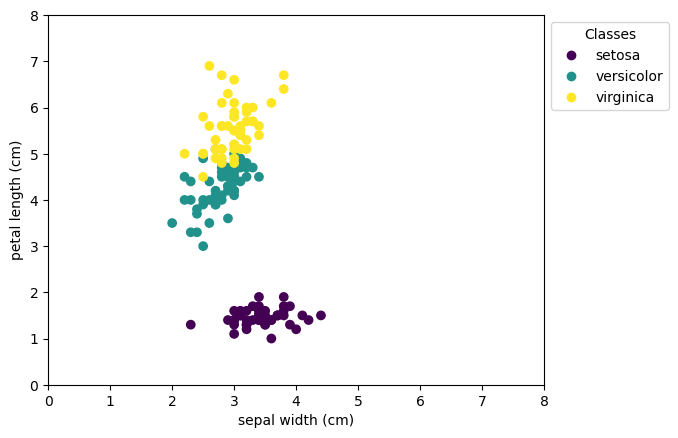

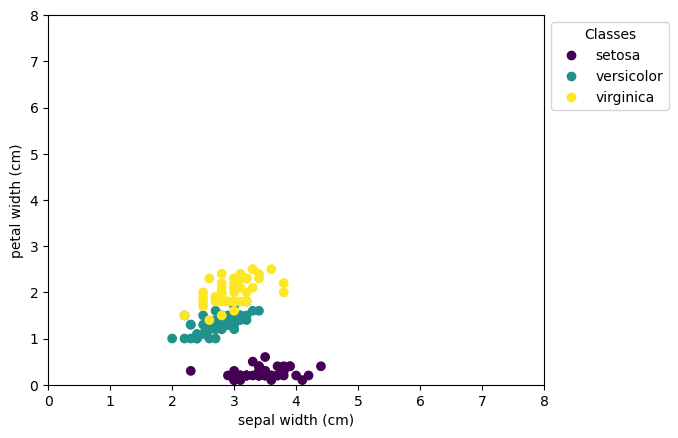

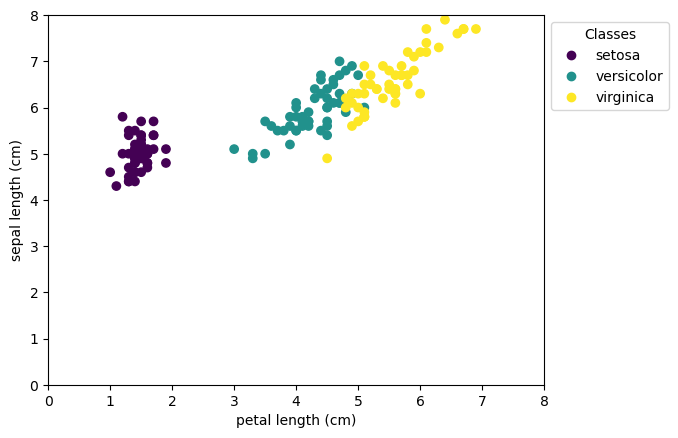

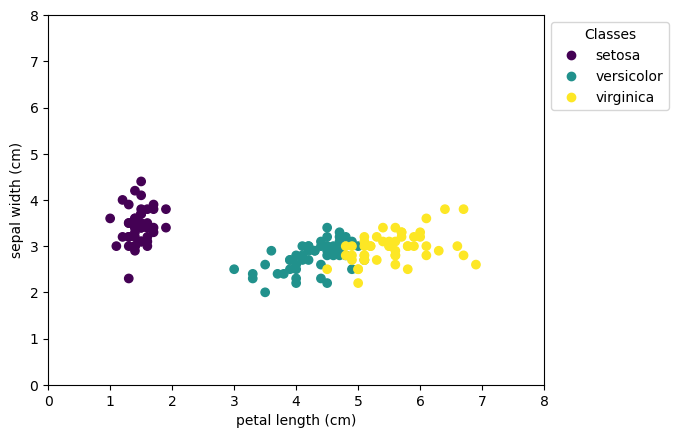

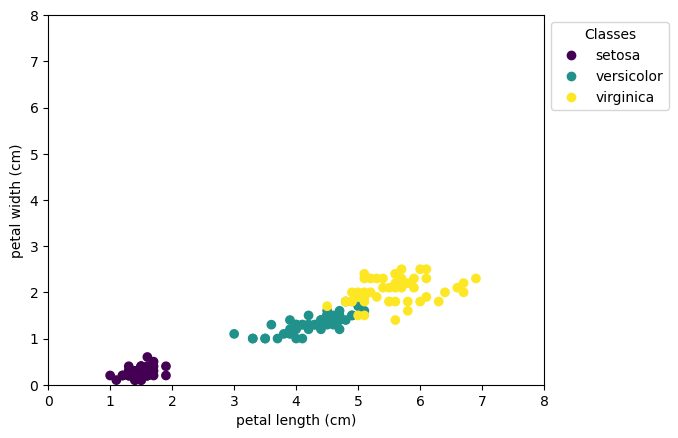

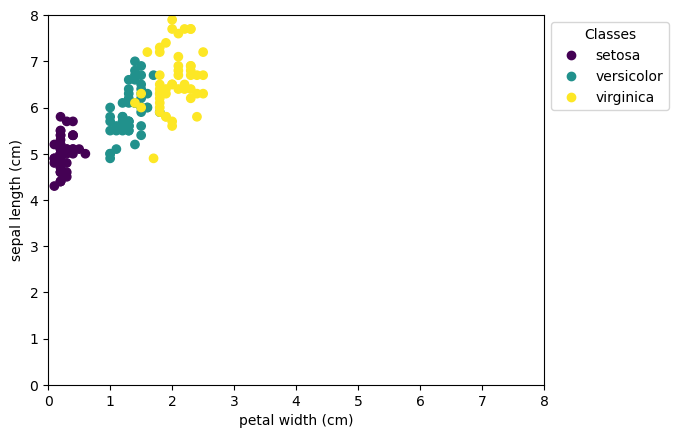

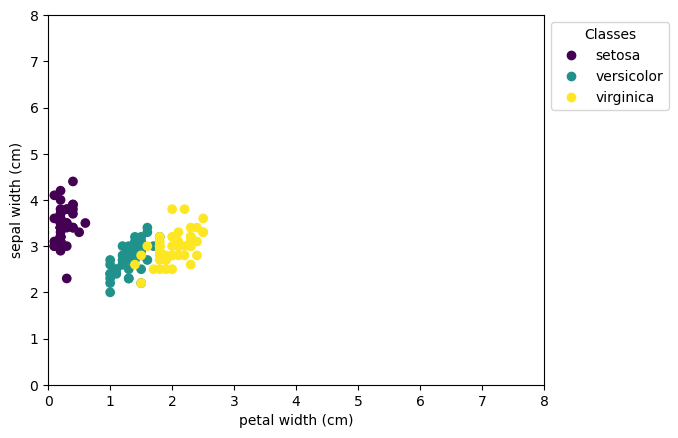

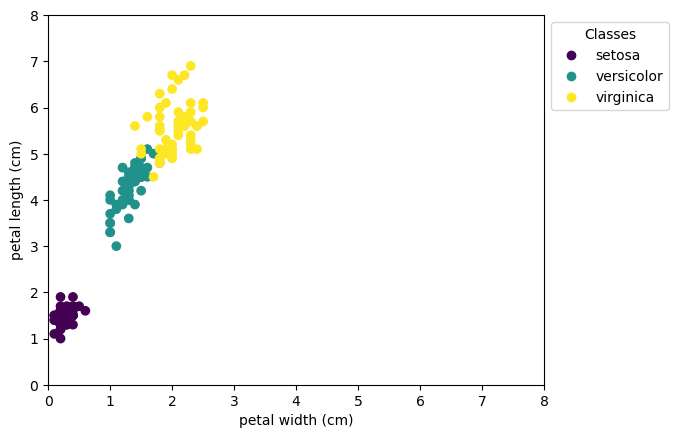

In [3]:
for i in range (0, 4):
    for j in range (0, 4):
        if i == j:
            continue
        _, ax = plt.subplots()
        scatter = ax.scatter(iris.data[:, i], iris.data[:, j], c=iris.target)
        ax.set(xlabel=iris.feature_names[i], ylabel=iris.feature_names[j])
        _ = ax.legend(
            scatter.legend_elements()[0], iris.target_names, loc="upper left", title="Classes", bbox_to_anchor=(1, 1)
        )
        plt.xlim(0, 8)
        plt.ylim(0, 8)


In [4]:

iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                        columns= iris['feature_names'] + ['target'])
print("Numero de elementos de cada clase")
print(iris_df['target'].value_counts())

iris_df = iris_df.query('target != 2')
# make all target 0 -1 only the target columns
iris_df


Numero de elementos de cada clase
target
0.0    50
1.0    50
2.0    50
Name: count, dtype: int64


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1.0
96,5.7,2.9,4.2,1.3,1.0
97,6.2,2.9,4.3,1.3,1.0
98,5.1,2.5,3.0,1.1,1.0


Funcion para nomralizar con L2 las 4 primeras columnas del dataframe

In [5]:
iris_shuffleados = iris_df.copy().sample(frac=1, random_state=0)

tamañoIris = len(iris_shuffleados)
tamañoTrain = int(tamañoIris * 0.8)

iris_trainAll = iris_shuffleados.iloc[:tamañoTrain]
iris_testAll = iris_shuffleados.iloc[tamañoTrain:]

Setosa = 0


#### Variables para el perceptron:
Los pesos iniciales los hardcodeamos para asi asegurarnos replicacion de datos:

In [6]:
num_entradas = 2

#pesosIniciales = tf.Variable(
    #tf.random.uniform([2, 1], minval=-1.0, maxval=1.0, dtype=tf.double))

#pesosIniciales = [[0.77264388],
#       [0.6640986 ]]
#pesosIniciales = tf.Variable(pesosIniciales)

pesosIniciales = []

for peso in range(2):
    pesosIniciales.append(random.uniform(-1, 1))

pesosIniciales


[0.792846855805504, -0.349652737789393]

Nos quedamos con el 80% de los datos para entrenar y el 0% para comprobar

In [7]:
iris_entrenamiento = tf.Variable(iris_trainAll.iloc[:, [0, 3, 4]].values)
iris_test = tf.Variable(iris_testAll.iloc[:, [0, 3, 4]].values)

In [8]:
pesosIniciales
data_list = []

##### Perceptron


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def salida_Perceptron(entradas, pesos, umbral):
    salida = 0
    for i in range(len(entradas)):
        salida += (entradas[i] * pesos[i] - umbral)
    if salida >= 0:
        return 1
    else:
        return 0

def entrenamiento_Perceptron(entradas, pesos, umbral, tasa_aprendizaje, salidas_esperadas):
    num_entradas = len(entradas[0])
    nuevos_pesos = pesos.copy()

    for i in range(len(salidas_esperadas)):
        entrada = entradas[i]
        salida_deseada = salidas_esperadas[i]
        error = salida_deseada - salida_Perceptron(entrada, nuevos_pesos, umbral)

        if error != 0:
            for j in range(num_entradas):
                nuevos_pesos[j] += tasa_aprendizaje * error * entrada[j]

    return nuevos_pesos

def Perceptron(entradas, salidas, pesos, umbrales, tasa_aprendizaje, num_iteraciones):
    mejor_precision = 0
    mejor_perdida = np.inf
    mejor_tasa_aprendizaje = None
    mejor_umbral = None
    mejor_pesos = None

    for tasa in tasa_aprendizaje:
        for umbral in umbrales:
            pesos = pesos.copy()
            for _ in range(num_iteraciones):
                pesos = entrenamiento_Perceptron(entradas, pesos, umbral, tasa, salidas)
                salidas_red = [salida_Perceptron(entrada, pesos, umbral) for entrada in entradas]

                precision = sum(salidas_red == salidas) / len(salidas)
                perdida = np.mean(np.abs(np.array(salidas_red) - np.array(salidas)))

                if 0.7 * perdida + 0.3 * precision < 0.7 * mejor_perdida + 0.3 * mejor_precision:
                    mejor_perdida = perdida
                    mejor_precision = precision
                    mejor_tasa_aprendizaje = tasa
                    mejor_umbral = umbral
                    mejor_pesos = pesos

    print(f"Mejor conjunto de hiperparámetros:")
    print(f"Tasa de aprendizaje: {mejor_tasa_aprendizaje}")
    print(f"Umbral: {mejor_umbral}")
    print(f"Pérdida: {mejor_perdida}")
    print(f"Precisión: {mejor_precision}")

    # Pintar solo el mejor conjunto de hiperparámetros
    x = entradas[:, 0]
    y = entradas[:, 1]
    x_range = np.linspace(0, 8, 100)  # Extender el rango de x de 0 a 8
    y_line = -(mejor_pesos[0] / mejor_pesos[1]) * x_range + mejor_umbral / mejor_pesos[1]

    # Pintar puntos de entrada según su salida
    plt.scatter(x[salidas == 1], y[salidas == 1], color='green', label='Versicolor')
    plt.scatter(x[salidas == 0], y[salidas == 0], color='red', label='Setosa')

    # Trazar la línea formada por los pesos y el umbral
    plt.plot(x_range, y_line, color='blue', label='Hiperplano separador')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Establecer límites de los ejes x e y
    plt.xlim(0, 8)
    plt.ylim(0, 8)

    # Quitar la cuadrícula de la gráfica
    plt.grid(False)

    # Mostrar leyenda fuera del gráfico principal
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

##### Comprobar resultados 

In [10]:
datos_entrenamiento = iris_entrenamiento[:, :-1]
target_entrenamiento = iris_entrenamiento[:, -1]
epochs = 400

datos_test = iris_test[:, :-1]
indices_test = iris_test[:, -1]

learning_rates = [0.1, 0.01, 0.001]
umbrales = [0.1, 0.3 , 0.5]

Perceptron(datos_entrenamiento, target_entrenamiento, pesosIniciales, umbrales, learning_rates, epochs)

TypeError: Cannot convert 0 to EagerTensor of dtype bool

In [ ]:
import pandas as pd

def save_data_to_csv(data_list):
    """
    Saves the given data list to a CSV file named 'training_data.csv'.

    Parameters:
    data_list (list): The list of data to be saved.

    Returns:
    None
    """
    df = pd.DataFrame(data_list)
    # Save the DataFrame to a CSV file
    df.to_csv("training_data.csv", index=False)

    print("Data saved to training_data.csv")


In [ ]:
import pandas as pd


def weighted_score(row):
    loss_weight = 0.7  # Adjust weights based on your problem's priorities
    accuracy_weight = 1 - loss_weight
    return (loss_weight * (1 - row["Loss"])) + (accuracy_weight * row["accuracy"])


# Add a column for the weighted score
data = pd.read_csv("gridSearchP1.csv")

In [ ]:
import pandas as pd


def weighted_score(row):
    loss_weight = 0.7  # Adjust weights based on your problem's priorities
    accuracy_weight = 1 - loss_weight
    return (loss_weight * (1 - row["loss"])) + (accuracy_weight * row["accuracy"])


# Add a column for the weighted score
data = pd.read_csv("gridSearchP1.csv")

data["weighted_score"] = data.apply(weighted_score, axis=1)

# Sort the data by the weighted score
data = data.sort_values(by="weighted_score", ascending=False)

data.head(10)

In [ ]:
print(tabulate.tabulate(data_list, headers='keys', tablefmt='pretty', ))

In [ ]:
pesosIniciales

#### Perceptron 3 entradas


In [ ]:
pesosIniciales3 = tf.Variable(
        tf.random.normal([3, 1], dtype=tf.double))

iris_entrenamiento = tf.Variable(iris_trainAll.iloc[:, [0,1, 2, 4]].values)
iris_test = tf.Variable(iris_testAll.iloc[:, [0,1, 2, 4]].values)

In [ ]:
datos_entrenamiento = iris_entrenamiento[:, :-1]
target_entrenamiento = iris_entrenamiento[:, -1]
epochs = 300

datos_test = iris_test[:, :-1]
indices_test = iris_test[:, -1]

# Lista de learning rates
learning_rates = [0.01, 0.05, 0.1, 0.5, 1.0]

learning_rate = 0.1
perceptron = Perceptron(Step(umbral), pesosIniciales3)
perceptron.fit(datos_entrenamiento, target_entrenamiento, epochs, learning_rate=learning_rate)

In [ ]:
for i in range(datos_test.shape[0]):
  sample = datos_test[i]
  prediction = perceptron.predict(sample)
  print(f"Sample {sample} with prediction {prediction} and target {indices_test[i]}")

#### Perceptron todas las entradas

In [ ]:
pesosIniciales4 = tf.Variable(
        tf.random.normal([4, 1], dtype=tf.double))

iris_entrenamiento = tf.Variable(iris_trainAll)
iris_test = tf.Variable(iris_testAll)

In [ ]:
datos_entrenamiento = iris_entrenamiento[:, :-1]
target_entrenamiento = iris_entrenamiento[:, -1]
epochs = 50

datos_test = iris_test[:, :-1]
indices_test = iris_test[:, -1]

# Lista de learning rates
learning_rates = [0.01, 0.05, 0.1, 0.5, 1.0]

learning_rate = 0.1
perceptron = Perceptron(Step(umbral), pesosIniciales4)
perceptron.fit(datos_entrenamiento, target_entrenamiento, epochs, learning_rate=learning_rate)

In [ ]:
for i in range(datos_test.shape[0]):
  sample = datos_test[i]
  prediction = perceptron.predict(sample)
  print(f"Sample {sample} with prediction {prediction} and target {indices_test[i]}")